# Denoising Autoencoders

we're going to train deep autoencoders and apply them to faces and similar images search.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Import stuff

In [1]:
import sys
sys.path.append("..")

In [2]:
import cv2 
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import download_utils
import keras_utils
import numpy as np
from keras_utils import reset_tf_session

Using TensorFlow backend.


In [3]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [4]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


1029

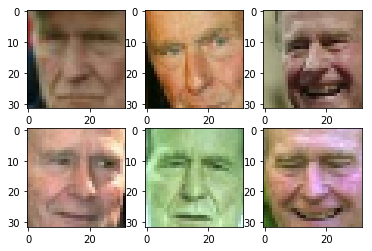

In [5]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

del X
import gc
gc.collect()

# Autoencoder architecture

In [6]:
def build_pca_autoencoder(img_shape, code_size):

    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder
    print(encoder.summary())
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    print(decoder.summary())
    return encoder,decoder

Meld them together into one model:

In [7]:
s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                98336     
Total params: 98,336
Trainable params: 98,336
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3072)              101376    
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 3)         0         
Total params: 101,376
Trainable params: 101,376
Non-trainable params: 0
_______________________________________________________



Epoch 2/15




Epoch 3/15




Epoch 4/15




Epoch 5/15




Epoch 6/15




Epoch 7/15




Epoch 8/15




Epoch 9/15




Epoch 10/15




Epoch 11/15




Epoch 12/15




Epoch 13/15




Epoch 14/15




Epoch 15/15


In [8]:
def visualize(img,encoder,decoder):
    code = encoder.predict(img[None])[0]  
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.006610649201254088


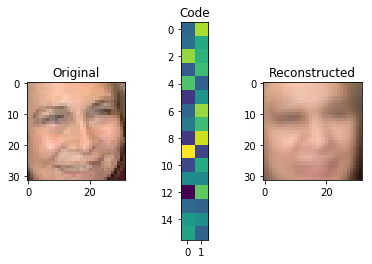

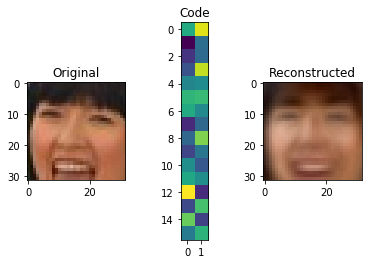

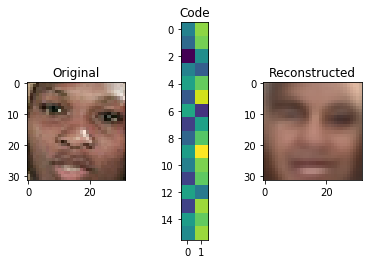

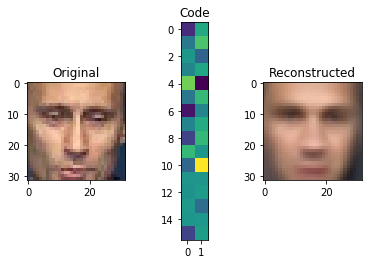

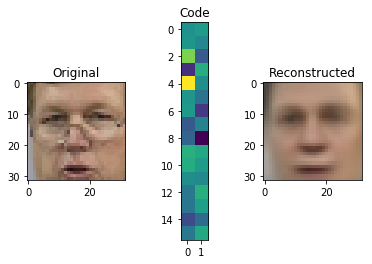

In [9]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [10]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(kernel_size=(3, 3), padding='same', filters=32, activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(kernel_size=(3, 3), padding='same', filters=64, activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(kernel_size=(3, 3), padding='same', filters=128, activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(kernel_size=(3, 3), padding='same', filters=256, activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())                  
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(2*2*256))
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3),
                                  strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3),
                                  strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3),
                                  strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3),
                                  strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [11]:
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)         295168    
__________

Convolutional autoencoder training. This will take **1 hour**. You're aiming at ~0.0056 validation MSE and ~0.0054 training MSE.

In [12]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [13]:
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

In [14]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.ModelSaveCallback(model_filename),
                           keras_utils.TqdmProgressCallback()],
                verbose=0,
                initial_epoch=last_finished_epoch or 0)


Epoch 1/25


Model saved in autoencoder.000.hdf5


Epoch 2/25


Model saved in autoencoder.001.hdf5


Epoch 3/25


Model saved in autoencoder.002.hdf5


Epoch 4/25


Model saved in autoencoder.003.hdf5


Epoch 5/25


Model saved in autoencoder.004.hdf5


Epoch 6/25


Model saved in autoencoder.005.hdf5


Epoch 7/25


Model saved in autoencoder.006.hdf5


Epoch 8/25


Model saved in autoencoder.007.hdf5


Epoch 9/25


Model saved in autoencoder.008.hdf5


Epoch 10/25


Model saved in autoencoder.009.hdf5


Epoch 11/25


Model saved in autoencoder.010.hdf5


Epoch 12/25


Model saved in autoencoder.011.hdf5


Epoch 13/25


Model saved in autoencoder.012.hdf5


Epoch 14/25


Model saved in autoencoder.013.hdf5


Epoch 15/25


Model saved in autoencoder.014.hdf5


Epoch 16/25


Model saved in autoencoder.015.hdf5


Epoch 17/25


Model saved in autoencoder.016.hdf5


Epoch 18/25


Model saved in autoencoder.017.hdf5


Epoch 19/25


Model saved in autoencoder.018.hdf5


Epoch 20/25


Model saved in autoencoder.019.hdf5


Epoch 21/25


Model saved in autoencoder.020.hdf5


Epoch 22/25


Model saved in autoencoder.021.hdf5


Epoch 23/25


Model saved in autoencoder.022.hdf5


Epoch 24/25


Model saved in autoencoder.023.hdf5


Epoch 25/25


Model saved in autoencoder.024.hdf5



Convolutional autoencoder MSE: 0.005484135231328951


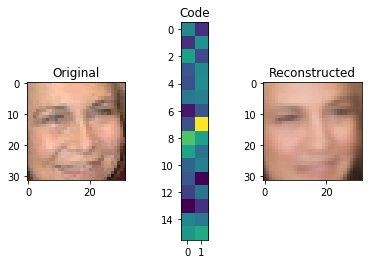

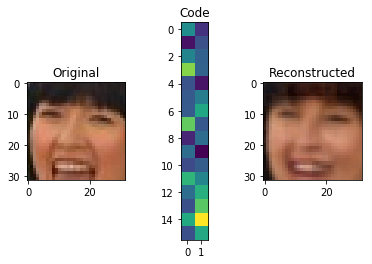

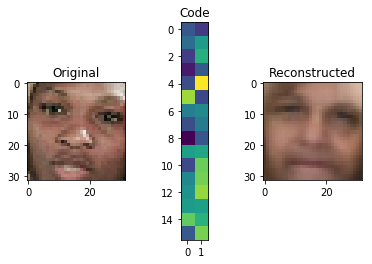

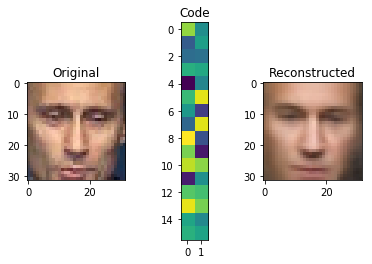

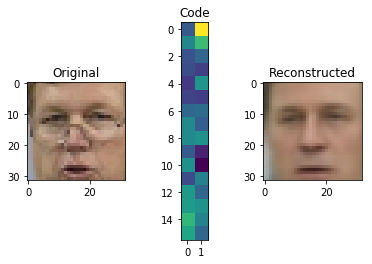

In [15]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [16]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [17]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.005484135231328951
0.005484135231328951


# Denoising Autoencoder


Let's now turn our model into a denoising autoencoder:
<img src="images/denoising.jpg" style="width:40%">

We'll keep the model architecture, but change the way it is trained. In particular, we'll corrupt its input data randomly with noise before each epoch.

There are many strategies to introduce noise: adding gaussian white noise, occluding with random black rectangles, etc. We will add gaussian white noise.

In [18]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from standard normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    Returns X + noise.
    """
    noise = np.random.normal(scale=sigma,size=X.shape)
    return X + noise

In [19]:
# noise tests
theoretical_std = (X_train[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X_train[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X_train[:100],sigma=0.5).mean() - X_train[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

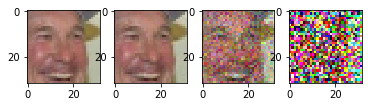

In [20]:
# test different noise scales
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

In [21]:
s = reset_tf_session()

# we use bigger code size here for better quality
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # we continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    callbacks=[keras_utils.TqdmProgressCallback()],
                    verbose=0)

Epoch 1/25, Generating corrupted samples...

Epoch 1/1



Epoch 2/25, Generating corrupted samples...

Epoch 1/1



Epoch 3/25, Generating corrupted samples...

Epoch 1/1



Epoch 4/25, Generating corrupted samples...

Epoch 1/1



Epoch 5/25, Generating corrupted samples...

Epoch 1/1



Epoch 6/25, Generating corrupted samples...

Epoch 1/1



Epoch 7/25, Generating corrupted samples...

Epoch 1/1



Epoch 8/25, Generating corrupted samples...

Epoch 1/1



Epoch 9/25, Generating corrupted samples...

Epoch 1/1



Epoch 10/25, Generating corrupted samples...

Epoch 1/1



Epoch 11/25, Generating corrupted samples...

Epoch 1/1



Epoch 12/25, Generating corrupted samples...

Epoch 1/1



Epoch 13/25, Generating corrupted samples...

Epoch 1/1



Epoch 14/25, Generating corrupted samples...

Epoch 1/1



Epoch 15/25, Generating corrupted samples...

Epoch 1/1



Epoch 16/25, Generating corrupted samples...

Epoch 1/1



Epoch 17/25, Generating corrupted samples...

Epoch 1/1



Epoch 18/25, Generating corrupted samples...

Epoch 1/1



Epoch 19/25, Generating corrupted samples...

Epoch 1/1



Epoch 20/25, Generating corrupted samples...

Epoch 1/1



Epoch 21/25, Generating corrupted samples...

Epoch 1/1



Epoch 22/25, Generating corrupted samples...

Epoch 1/1



Epoch 23/25, Generating corrupted samples...

Epoch 1/1



Epoch 24/25, Generating corrupted samples...

Epoch 1/1



Epoch 25/25, Generating corrupted samples...

Epoch 1/1


Denoising MSE: 0.002763783381083279


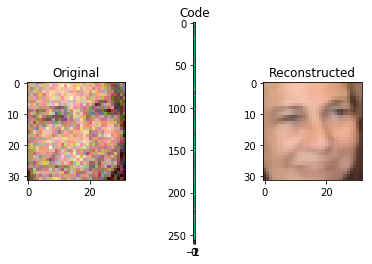

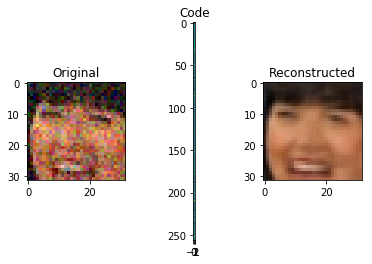

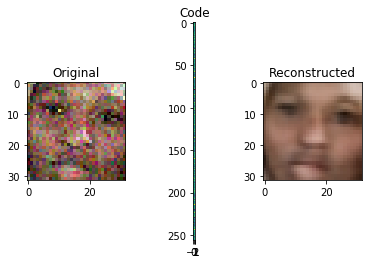

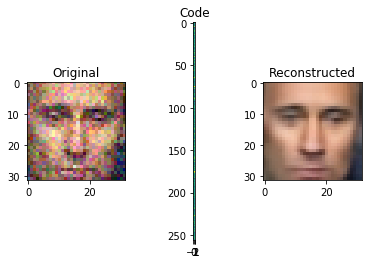

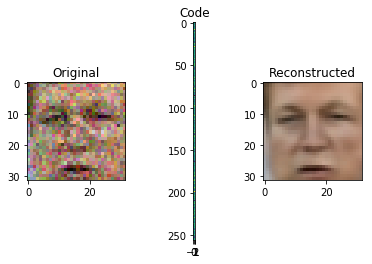

In [22]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

# Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see them in action.

First thing we can do is image retrieval aka image search. We will give it an image and find similar images in latent space:

<img src="images/similar_images.jpg" style="width:60%">

To speed up retrieval process, one should use Locality Sensitive Hashing on top of encoded vectors. This [technique](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) can narrow down the potential nearest neighbours of our image in latent space (encoder code). We will caclulate nearest neighbours in brute force way for simplicity.

In [23]:
# restore trained encoder weights
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")

In [24]:
images = X_train
codes =[encoder.predict(img[None])[0] for img in images]
assert len(codes) == len(images)


In [25]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [26]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [27]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Cherry-picked examples:

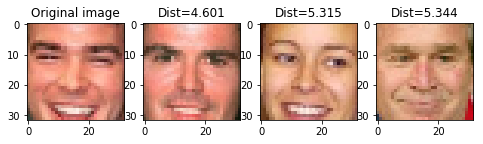

In [28]:
# smiles
show_similar(X_test[247])

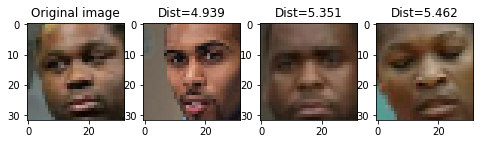

In [29]:
# ethnicity
show_similar(X_test[56])

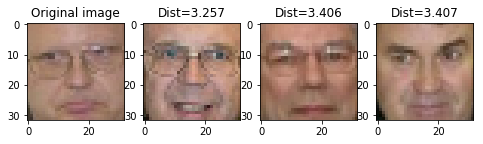

In [30]:
# glasses
show_similar(X_test[63])

# Cheap image morphing


We can take linear combinations of image codes to produce new images with decoder.

In [31]:
# restore trained encoder weights
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

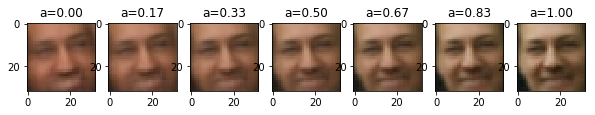

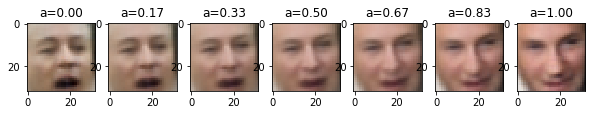

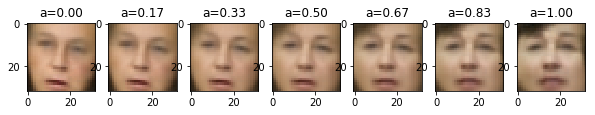

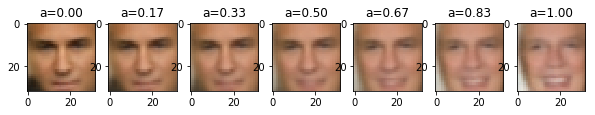

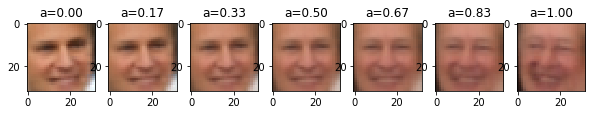

In [32]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        show_image(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()